In [1]:
library(pROC)
library(ggplot2)
library(caret)
theme_set(theme_minimal())
mydata=read.csv("Troponin.csv")
names(mydata)

Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var


Loading required package: lattice



[1] "id"                "age"               "age_binary"       
 [4] "gender"            "GFR"               "renal_dysfunction"
 [7] "admitted"          "admitted_cardiac"  "MI"               
[10] "cardiac_catheter"  "IPDAT_report"      "test_date"        
[13] "receipt_date"      "diff"              "diff_r"           
[16] "CGRD_T0"           "CGRD_T3"           "Roche_T0"         
[19] "Roche_T3"          "delta_Roche"       "delta_Roche_per"  
[22] "Beckman_T0"        "Beckman_T3"        "delta_Beckman"    
[25] "delta_Beckman_per" "Abbott_T0"         "Abbott_T3"        
[28] "delta_Abbott"      "delta_Abbott_per"  "Creatinine_T0"    
[31] "Creatinine_T3"

In [2]:
mydata=as.data.frame(mydata)
head(mydata)

,id,age,age_binary,gender,GFR,renal_dysfunction,admitted,admitted_cardiac,MI,cardiac_catheter,⋯,Beckman_T0,Beckman_T3,delta_Beckman,delta_Beckman_per,Abbott_T0,Abbott_T3,delta_Abbott,delta_Abbott_per,Creatinine_T0,Creatinine_T3
,<chr>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>
1,10199119,62,0,0,107.71,0,0,0,0,0,⋯,6.38,8,1,21,4.5,9,4,93,1,1
2,1044197,87,1,0,50.51,1,0,0,0,0,⋯,3.65,4,1,18,4.4,5,1,11,1,1
3,10588102,26,0,0,131.41,0,0,0,0,0,⋯,0.85,0,1,62,2.3,2,0,13,1,1
4,1073023,62,0,1,21.43,1,0,0,0,0,⋯,25.59,32,6,25,13.0,16,3,21,3,3
5,1098123,71,1,1,59.37,1,0,0,0,0,⋯,3.61,4,1,16,2.7,3,1,19,1,1
6,1107763,60,0,0,2.44,1,0,0,0,0,⋯,14.43,23,9,62,17.4,26,9,51,16,16


## Roche: Overall

In [3]:
mydata_Roche=mydata[,c('id',
                       'age',
                       'age_binary',
                       'gender',
                       'GFR',
                       'renal_dysfunction',
                       'admitted',
                       'admitted_cardiac',
                       'MI',
                       'cardiac_catheter',
                       'IPDAT_report',
                       'test_date',
                       'receipt_date',
                       'diff',
                       'diff_r',
                       'CGRD_T0',
                       'CGRD_T3',
                       'Roche_T0',
                       'Roche_T3',
                       'delta_Roche',
                       'delta_Roche_per')]

In [4]:
mydata_Roche$Roche_T0bellow99th=ifelse(mydata_Roche$Roche_T0<=14,1,0)
mydata_Roche$Roche_T0bellow5X99th=ifelse(mydata_Roche$Roche_T0<=14*5,1,0)
mydata_Roche$Roche_T3bellow99th=ifelse(mydata_Roche$Roche_T3<=14,1,0)
mydata_Roche$Roche_delta_perbellow20=ifelse(mydata_Roche$delta_Roche_per<=20,1,0)

In [5]:
mydata_Roche$Roche_pred=array(0,nrow(mydata_Roche))
for(i in 1:nrow(mydata_Roche)){
  mydata_Roche$Roche_pred[i]=if(mydata_Roche$Roche_T0bellow99th[i]==1 && mydata_Roche$Roche_T3bellow99th[i]==1){
    "Rule_out" 
 } else if(mydata_Roche$Roche_T0bellow99th[i]==1 && mydata_Roche$Roche_T3bellow99th[i]==0 && mydata_Roche$delta_Roche_per[i]<=50){
    "Observe"
 } else if(mydata_Roche$Roche_T0bellow99th[i]==1 && mydata_Roche$Roche_T3bellow99th[i]==0 && mydata_Roche$delta_Roche_per[i]>50){
    "Rule_in"
 } else if(mydata_Roche$Roche_T0bellow99th[i]==0 && mydata_Roche$Roche_T0bellow5X99th[i]==0){
    "Rule_in"
 } else if(mydata_Roche$Roche_T0bellow99th[i]==0 && mydata_Roche$Roche_T0bellow5X99th[i]==1 && mydata_Roche$Roche_T3bellow99th[i]==1){
    "Rule_out"
 } else if(mydata_Roche$Roche_T0bellow99th[i]==0 && mydata_Roche$Roche_T0bellow5X99th[i]==1 && mydata_Roche$Roche_T3bellow99th[i]==0 && mydata_Roche$Roche_delta_perbellow20[i]==1){
    "Observe"
 } else {
    "Rule_in"
 }
      }

table(mydata_Roche$Roche_pred,mydata_Roche$MI)
prevalence_Roche=sum(mydata_Roche$MI)/nrow(mydata_Roche)
prevalence_Roche

          
            0  1
  Observe  38  0
  Rule_in  50 11
  Rule_out 28  0

[1] 0.08661417

## Roche: Age>70

In [6]:
mydata_Roche_old=mydata_Roche[which(mydata_Roche$age_binary==1),]
head(mydata_Roche_old)

,id,age,age_binary,gender,GFR,renal_dysfunction,admitted,admitted_cardiac,MI,cardiac_catheter,⋯,CGRD_T3,Roche_T0,Roche_T3,delta_Roche,delta_Roche_per,Roche_T0bellow99th,Roche_T0bellow5X99th,Roche_T3bellow99th,Roche_delta_perbellow20,Roche_pred
,<chr>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2,1044197,87,1,0,50.51,1,0,0,0,0,⋯,26,25.90,25,1,2,0,1,0,1,Observe
5,1098123,71,1,1,59.37,1,0,0,0,0,⋯,12,9.58,12,2,21,1,1,1,0,Rule_out
7,147950,86,1,1,8.83,1,1,0,0,0,⋯,204,218.00,217,1,0,0,0,0,1,Rule_in
8,150547,78,1,0,11.35,1,1,0,0,0,⋯,79,79.80,82,2,3,0,0,0,1,Rule_in
12,2030944,79,1,1,50.33,1,0,0,0,0,⋯,64,68.70,64,5,7,0,1,0,1,Observe
14,2396492,72,1,0,100.43,0,0,0,0,0,⋯,10,11.10,10,1,10,1,1,1,1,Rule_out


In [7]:
mydata_Roche_old$Roche_T0bellow99th=ifelse(mydata_Roche_old$Roche_T0<=54,1,0)
mydata_Roche_old$Roche_T0bellow5X99th=ifelse(mydata_Roche_old$Roche_T0<=54*5,1,0)
mydata_Roche_old$Roche_T3bellow99th=ifelse(mydata_Roche_old$Roche_T3<=54,1,0)
mydata_Roche_old$Roche_delta_perbellow20=ifelse(mydata_Roche_old$delta_Roche_per<=20,1,0)

In [8]:
mydata_Roche_old$Roche_pred=array(0,nrow(mydata_Roche_old))
for(i in 1:nrow(mydata_Roche_old)){
  mydata_Roche_old$Roche_pred[i]=if(mydata_Roche_old$Roche_T0bellow99th[i]==1 && mydata_Roche_old$Roche_T3bellow99th[i]==1){
    "Rule_out" 
 } else if(mydata_Roche_old$Roche_T0bellow99th[i]==1 && mydata_Roche_old$Roche_T3bellow99th[i]==0 && mydata_Roche_old$delta_Roche_per[i]<=50){
    "Observe"
 } else if(mydata_Roche_old$Roche_T0bellow99th[i]==1 && mydata_Roche_old$Roche_T3bellow99th[i]==0 && mydata_Roche_old$delta_Roche_per[i]>50){
    "Rule_in"
 } else if(mydata_Roche_old$Roche_T0bellow99th[i]==0 && mydata_Roche_old$Roche_T0bellow5X99th[i]==0){
    "Rule_in"
 } else if(mydata_Roche_old$Roche_T0bellow99th[i]==0 && mydata_Roche_old$Roche_T0bellow5X99th[i]==1 && mydata_Roche_old$Roche_T3bellow99th[i]==1){
    "Rule_out"
 } else if(mydata_Roche_old$Roche_T0bellow99th[i]==0 && mydata_Roche_old$Roche_T0bellow5X99th[i]==1 && mydata_Roche_old$Roche_T3bellow99th[i]==0 && mydata_Roche_old$Roche_delta_perbellow20[i]==1){
    "Observe"
 } else {
    "Rule_in"
 }
      }
      
table(mydata_Roche_old$Roche_pred,mydata_Roche_old$MI)
prevalence_Roche_old=sum(mydata_Roche_old$MI)/nrow(mydata_Roche_old)
prevalence_Roche_old

          
            0  1
  Observe  22  0
  Rule_in  10  3
  Rule_out 34  0

[1] 0.04347826

## Roche: Gender (Male)

In [9]:
mydata_Roche_male=mydata_Roche[which(mydata_Roche$gender==1),]
head(mydata_Roche_male)

,id,age,age_binary,gender,GFR,renal_dysfunction,admitted,admitted_cardiac,MI,cardiac_catheter,⋯,CGRD_T3,Roche_T0,Roche_T3,delta_Roche,delta_Roche_per,Roche_T0bellow99th,Roche_T0bellow5X99th,Roche_T3bellow99th,Roche_delta_perbellow20,Roche_pred
,<chr>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
4,1073023,62,0,1,21.43,1,0,0,0,0,⋯,137,138.00,134,4,3,0,0,0,1,Rule_in
5,1098123,71,1,1,59.37,1,0,0,0,0,⋯,12,9.58,12,2,21,1,1,1,0,Rule_out
7,147950,86,1,1,8.83,1,1,0,0,0,⋯,204,218.00,217,1,0,0,0,0,1,Rule_in
12,2030944,79,1,1,50.33,1,0,0,0,0,⋯,64,68.70,64,5,7,0,1,0,1,Observe
15,2694486,57,0,1,5.52,1,1,0,0,0,⋯,267,260.00,265,5,2,0,0,0,1,Rule_in
16,3036649,57,0,1,34.78,1,1,0,0,0,⋯,51,54.60,52,2,4,0,1,0,1,Observe


In [10]:
mydata_Roche_male$Roche_T0bellow99th=ifelse(mydata_Roche_male$Roche_T0<=16,1,0)
mydata_Roche_male$Roche_T0bellow5X99th=ifelse(mydata_Roche_male$Roche_T0<=16*5,1,0)
mydata_Roche_male$Roche_T3bellow99th=ifelse(mydata_Roche_male$Roche_T3<=16,1,0)
mydata_Roche_male$Roche_delta_perbellow20=ifelse(mydata_Roche_male$delta_Roche_per<=20,1,0)

In [11]:
mydata_Roche_male$Roche_pred=array(0,nrow(mydata_Roche_male))
for(i in 1:nrow(mydata_Roche_male)){
  mydata_Roche_male$Roche_pred[i]=if(mydata_Roche_male$Roche_T0bellow99th[i]==1 && mydata_Roche_male$Roche_T3bellow99th[i]==1){
    "Rule_out" 
 } else if(mydata_Roche_male$Roche_T0bellow99th[i]==1 && mydata_Roche_male$Roche_T3bellow99th[i]==0 && mydata_Roche_male$delta_Roche_per[i]<=50){
    "Observe"
 } else if(mydata_Roche_male$Roche_T0bellow99th[i]==1 && mydata_Roche_male$Roche_T3bellow99th[i]==0 && mydata_Roche_male$delta_Roche_per[i]>50){
    "Rule_in"
 } else if(mydata_Roche_male$Roche_T0bellow99th[i]==0 && mydata_Roche_male$Roche_T0bellow5X99th[i]==0){
    "Rule_in"
 } else if(mydata_Roche_male$Roche_T0bellow99th[i]==0 && mydata_Roche_male$Roche_T0bellow5X99th[i]==1 && mydata_Roche_male$Roche_T3bellow99th[i]==1){
    "Rule_out"
 } else if(mydata_Roche_male$Roche_T0bellow99th[i]==0 && mydata_Roche_male$Roche_T0bellow5X99th[i]==1 && mydata_Roche_male$Roche_T3bellow99th[i]==0 && mydata_Roche_male$Roche_delta_perbellow20[i]==1){
    "Observe"
 } else {
    "Rule_in"
 }
      }
      
table(mydata_Roche_male$Roche_pred,mydata_Roche_male$MI)
prevalence_Roche_male=sum(mydata_Roche_male$MI)/nrow(mydata_Roche_male)
prevalence_Roche_male

          
            0  1
  Observe  20  0
  Rule_in  28  9
  Rule_out 14  0

[1] 0.1267606

## Roche: Gender (Female)

In [12]:
mydata_Roche_female=mydata_Roche[which(mydata_Roche$gender==0),]
head(mydata_Roche_female)

,id,age,age_binary,gender,GFR,renal_dysfunction,admitted,admitted_cardiac,MI,cardiac_catheter,⋯,CGRD_T3,Roche_T0,Roche_T3,delta_Roche,delta_Roche_per,Roche_T0bellow99th,Roche_T0bellow5X99th,Roche_T3bellow99th,Roche_delta_perbellow20,Roche_pred
,<chr>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,10199119,62,0,0,107.71,0,0,0,0,0,⋯,11,9.55,12,3,28,1,1,1,0,Rule_out
2,1044197,87,1,0,50.51,1,0,0,0,0,⋯,26,25.90,25,1,2,0,1,0,1,Observe
3,10588102,26,0,0,131.41,0,0,0,0,0,⋯,3,3.00,3,0,0,1,1,1,1,Rule_out
6,1107763,60,0,0,2.44,1,0,0,0,0,⋯,37,28.60,38,9,33,0,1,0,0,Rule_in
8,150547,78,1,0,11.35,1,1,0,0,0,⋯,79,79.80,82,2,3,0,0,0,1,Rule_in
9,1839516,44,0,0,109.26,0,1,0,0,0,⋯,273,270.00,271,1,0,0,0,0,1,Rule_in


In [13]:
mydata_Roche_female$Roche_T0bellow99th=ifelse(mydata_Roche_female$Roche_T0<=11,1,0)
mydata_Roche_female$Roche_T0bellow5X99th=ifelse(mydata_Roche_female$Roche_T0<=11*5,1,0)
mydata_Roche_female$Roche_T3bellow99th=ifelse(mydata_Roche_female$Roche_T3<=11,1,0)
mydata_Roche_female$Roche_delta_perbellow20=ifelse(mydata_Roche_female$delta_Roche_per<=20,1,0)

In [14]:
mydata_Roche_female$Roche_pred=array(0,nrow(mydata_Roche_female))
for(i in 1:nrow(mydata_Roche_female)){
  mydata_Roche_female$Roche_pred[i]=if(mydata_Roche_female$Roche_T0bellow99th[i]==1 && mydata_Roche_female$Roche_T3bellow99th[i]==1){
    "Rule_out" 
 } else if(mydata_Roche_female$Roche_T0bellow99th[i]==1 && mydata_Roche_female$Roche_T3bellow99th[i]==0 && mydata_Roche_female$delta_Roche_per[i]<=50){
    "Observe"
 } else if(mydata_Roche_female$Roche_T0bellow99th[i]==1 && mydata_Roche_female$Roche_T3bellow99th[i]==0 && mydata_Roche_female$delta_Roche_per[i]>50){
    "Rule_in"
 } else if(mydata_Roche_female$Roche_T0bellow99th[i]==0 && mydata_Roche_female$Roche_T0bellow5X99th[i]==0){
    "Rule_in"
 } else if(mydata_Roche_female$Roche_T0bellow99th[i]==0 && mydata_Roche_female$Roche_T0bellow5X99th[i]==1 && mydata_Roche_female$Roche_T3bellow99th[i]==1){
    "Rule_out"
 } else if(mydata_Roche_female$Roche_T0bellow99th[i]==0 && mydata_Roche_female$Roche_T0bellow5X99th[i]==1 && mydata_Roche_female$Roche_T3bellow99th[i]==0 && mydata_Roche_female$Roche_delta_perbellow20[i]==1){
    "Observe"
 } else {
    "Rule_in"
 }
      }
      
table(mydata_Roche_female$Roche_pred,mydata_Roche_female$MI)
prevalence_Roche_female=sum(mydata_Roche_female$MI)/nrow(mydata_Roche_female)
prevalence_Roche_female

          
            0  1
  Observe  20  0
  Rule_in  20  2
  Rule_out 14  0

[1] 0.03571429

## Roche: eGFR<60

In [15]:
mydata_Roche_GFR=mydata_Roche[which(mydata_Roche$GFR<60),]
head(mydata_Roche_GFR)

,id,age,age_binary,gender,GFR,renal_dysfunction,admitted,admitted_cardiac,MI,cardiac_catheter,⋯,CGRD_T3,Roche_T0,Roche_T3,delta_Roche,delta_Roche_per,Roche_T0bellow99th,Roche_T0bellow5X99th,Roche_T3bellow99th,Roche_delta_perbellow20,Roche_pred
,<chr>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2,1044197,87,1,0,50.51,1,0,0,0,0,⋯,26,25.90,25,1,2,0,1,0,1,Observe
4,1073023,62,0,1,21.43,1,0,0,0,0,⋯,137,138.00,134,4,3,0,0,0,1,Rule_in
5,1098123,71,1,1,59.37,1,0,0,0,0,⋯,12,9.58,12,2,21,1,1,1,0,Rule_out
6,1107763,60,0,0,2.44,1,0,0,0,0,⋯,37,28.60,38,9,33,0,1,0,0,Rule_in
7,147950,86,1,1,8.83,1,1,0,0,0,⋯,204,218.00,217,1,0,0,0,0,1,Rule_in
8,150547,78,1,0,11.35,1,1,0,0,0,⋯,79,79.80,82,2,3,0,0,0,1,Rule_in


In [16]:
mydata_Roche_GFR$Roche_T0bellow99th=ifelse(mydata_Roche_GFR$Roche_T0<=29.5,1,0)
mydata_Roche_GFR$Roche_T0bellow5X99th=ifelse(mydata_Roche_GFR$Roche_T0<=29.5*5,1,0)
mydata_Roche_GFR$Roche_T3bellow99th=ifelse(mydata_Roche_GFR$Roche_T3<=29.5,1,0)
mydata_Roche_GFR$Roche_delta_perbellow20=ifelse(mydata_Roche_GFR$delta_Roche_per<=20,1,0)

In [17]:
mydata_Roche_GFR$Roche_pred=array(0,nrow(mydata_Roche_GFR))
for(i in 1:nrow(mydata_Roche_GFR)){
  mydata_Roche_GFR$Roche_pred[i]=if(mydata_Roche_GFR$Roche_T0bellow99th[i]==1 && mydata_Roche_GFR$Roche_T3bellow99th[i]==1){
    "Rule_out" 
 } else if(mydata_Roche_GFR$Roche_T0bellow99th[i]==1 && mydata_Roche_GFR$Roche_T3bellow99th[i]==0 && mydata_Roche_GFR$delta_Roche_per[i]<=50){
    "Observe"
 } else if(mydata_Roche_GFR$Roche_T0bellow99th[i]==1 && mydata_Roche_GFR$Roche_T3bellow99th[i]==0 && mydata_Roche_GFR$delta_Roche_per[i]>50){
    "Rule_in"
 } else if(mydata_Roche_GFR$Roche_T0bellow99th[i]==0 && mydata_Roche_GFR$Roche_T0bellow5X99th[i]==0){
    "Rule_in"
 } else if(mydata_Roche_GFR$Roche_T0bellow99th[i]==0 && mydata_Roche_GFR$Roche_T0bellow5X99th[i]==1 && mydata_Roche_GFR$Roche_T3bellow99th[i]==1){
    "Rule_out"
 } else if(mydata_Roche_GFR$Roche_T0bellow99th[i]==0 && mydata_Roche_GFR$Roche_T0bellow5X99th[i]==1 && mydata_Roche_GFR$Roche_T3bellow99th[i]==0 && mydata_Roche_GFR$Roche_delta_perbellow20[i]==1){
    "Observe"
 } else {
    "Rule_in"
 }
      }
      
table(mydata_Roche_GFR$Roche_pred,mydata_Roche_GFR$MI)
prevalence_Roche_GFR=sum(mydata_Roche_GFR$MI)/nrow(mydata_Roche_GFR)
prevalence_Roche_GFR

          
            0  1
  Observe  32  0
  Rule_in  22  6
  Rule_out 20  0

[1] 0.075

## Abbott: Overall

In [18]:
mydata_Abbott=mydata[,c('id',
                        'age',
                        'age_binary',
                        'gender',
                        'GFR',
                        'renal_dysfunction',
                        'admitted',
                        'admitted_cardiac',
                        'MI',
                        'cardiac_catheter',
                        'IPDAT_report',
                        'test_date',
                        'receipt_date',
                        'diff',
                        'diff_r',
                        'CGRD_T0',
                        'CGRD_T3',
                        'Abbott_T0',
                        'Abbott_T3',
                        'delta_Abbott',
                        'delta_Abbott_per')]

In [19]:
mydata_Abbott$Abbott_T0bellow99th=ifelse(mydata_Abbott$Abbott_T0<=26,1,0)
mydata_Abbott$Abbott_T0bellow5X99th=ifelse(mydata_Abbott$Abbott_T0<=26*5,1,0)
mydata_Abbott$Abbott_T3bellow99th=ifelse(mydata_Abbott$Abbott_T3<=26,1,0)
mydata_Abbott$Abbott_delta_perbellow20=ifelse(mydata_Abbott$delta_Abbott_per<=20,1,0)
mydata_Abbott$Abbott_delta_perbellow50=ifelse(mydata_Abbott$delta_Abbott_per<=50,1,0)

In [20]:
mydata_Abbott$Abbott_pred=array(0,nrow(mydata_Abbott))
for(i in 1:nrow(mydata_Abbott)){
  mydata_Abbott$Abbott_pred[i]=if(mydata_Abbott$Abbott_T0bellow99th[i]==1 && mydata_Abbott$Abbott_T3bellow99th[i]==1){
    "Rule_out" 
 } else if(mydata_Abbott$Abbott_T0bellow99th[i]==1 && mydata_Abbott$Abbott_T3bellow99th[i]==0 && mydata_Abbott$Abbott_delta_perbellow50[i]==1){
    "Observe"
 } else if(mydata_Abbott$Abbott_T0bellow99th[i]==1 && mydata_Abbott$Abbott_T3bellow99th[i]==0 && mydata_Abbott$Abbott_delta_perbellow50[i]==0){
    "Rule_in"
 } else if(mydata_Abbott$Abbott_T0bellow99th[i]==0 && mydata_Abbott$Abbott_T0bellow5X99th[i]==0){
    "Rule_in"
 } else if(mydata_Abbott$Abbott_T0bellow99th[i]==0 && mydata_Abbott$Abbott_T0bellow5X99th[i]==1 && mydata_Abbott$Abbott_T3bellow99th[i]==1){
    "Rule_out"
 } else if(mydata_Abbott$Abbott_T0bellow99th[i]==0 && mydata_Abbott$Abbott_T0bellow5X99th[i]==1 && mydata_Abbott$Abbott_T3bellow99th[i]==0 && mydata_Abbott$Abbott_delta_perbellow20[i]==1){
    "Observe"
 } else {
    "Rule_in"
 }
      }

table(mydata_Abbott$Abbott_pred,mydata_Abbott$MI)
prevalence_Abbott=sum(mydata_Abbott$MI)/nrow(mydata_Abbott)
prevalence_Abbott

          
            0  1
  Observe  22  1
  Rule_in  41 10
  Rule_out 53  0

[1] 0.08661417

## Abbott: Age>70

In [21]:
mydata_Abbott_old=mydata_Abbott[which(mydata_Abbott$age_binary==1),]
head(mydata_Abbott_old)

,id,age,age_binary,gender,GFR,renal_dysfunction,admitted,admitted_cardiac,MI,cardiac_catheter,⋯,Abbott_T0,Abbott_T3,delta_Abbott,delta_Abbott_per,Abbott_T0bellow99th,Abbott_T0bellow5X99th,Abbott_T3bellow99th,Abbott_delta_perbellow20,Abbott_delta_perbellow50,Abbott_pred
,<chr>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2,1044197,87,1,0,50.51,1,0,0,0,0,⋯,4.4,5,1,11,1,1,1,1,1,Rule_out
5,1098123,71,1,1,59.37,1,0,0,0,0,⋯,2.7,3,1,19,1,1,1,1,1,Rule_out
7,147950,86,1,1,8.83,1,1,0,0,0,⋯,66.8,67,0,0,0,1,0,1,1,Observe
8,150547,78,1,0,11.35,1,1,0,0,0,⋯,11.1,14,2,22,1,1,1,0,1,Rule_out
12,2030944,79,1,1,50.33,1,0,0,0,0,⋯,36.1,33,3,9,0,1,0,1,1,Observe
14,2396492,72,1,0,100.43,0,0,0,0,0,⋯,4.0,4,0,8,1,1,1,1,1,Rule_out


In [22]:
mydata_Abbott_old$Abbott_T0bellow99th=ifelse(mydata_Abbott_old$Abbott_T0<=32,1,0)
mydata_Abbott_old$Abbott_T0bellow5X99th=ifelse(mydata_Abbott_old$Abbott_T0<=32*5,1,0)
mydata_Abbott_old$Abbott_T3bellow99th=ifelse(mydata_Abbott_old$Abbott_T3<=32,1,0)
mydata_Abbott_old$Abbott_delta_perbellow20=ifelse(mydata_Abbott_old$delta_Abbott_per<=20,1,0)

In [23]:
mydata_Abbott_old$Abbott_pred=array(0,nrow(mydata_Abbott_old))
for(i in 1:nrow(mydata_Abbott_old)){
  mydata_Abbott_old$Abbott_pred[i]=if(mydata_Abbott_old$Abbott_T0bellow99th[i]==1 && mydata_Abbott_old$Abbott_T3bellow99th[i]==1){
    "Rule_out" 
 } else if(mydata_Abbott_old$Abbott_T0bellow99th[i]==1 && mydata_Abbott_old$Abbott_T3bellow99th[i]==0 && mydata_Abbott_old$delta_Abbott_per[i]<=50){
    "Observe"
 } else if(mydata_Abbott_old$Abbott_T0bellow99th[i]==1 && mydata_Abbott_old$Abbott_T3bellow99th[i]==0 && mydata_Abbott_old$delta_Abbott_per[i]>50){
    "Rule_in"
 } else if(mydata_Abbott_old$Abbott_T0bellow99th[i]==0 && mydata_Abbott_old$Abbott_T0bellow5X99th[i]==0){
    "Rule_in"
 } else if(mydata_Abbott_old$Abbott_T0bellow99th[i]==0 && mydata_Abbott_old$Abbott_T0bellow5X99th[i]==1 && mydata_Abbott_old$Abbott_T3bellow99th[i]==1){
    "Rule_out"
 } else if(mydata_Abbott_old$Abbott_T0bellow99th[i]==0 && mydata_Abbott_old$Abbott_T0bellow5X99th[i]==1 && mydata_Abbott_old$Abbott_T3bellow99th[i]==0 && mydata_Abbott_old$Abbott_delta_perbellow20[i]==1){
    "Observe"
 } else {
    "Rule_in"
 }
      }
      
table(mydata_Abbott_old$Abbott_pred,mydata_Abbott_old$MI)
prevalence_Abbott_old=sum(mydata_Abbott_old$MI)/nrow(mydata_Abbott_old)
prevalence_Abbott_old

          
            0  1
  Observe   9  0
  Rule_in  24  3
  Rule_out 33  0

[1] 0.04347826

## Abbott: Gender (Male)

In [24]:
mydata_Abbott_male=mydata_Abbott[which(mydata_Abbott$gender==1),]
head(mydata_Abbott_male)

,id,age,age_binary,gender,GFR,renal_dysfunction,admitted,admitted_cardiac,MI,cardiac_catheter,⋯,Abbott_T0,Abbott_T3,delta_Abbott,delta_Abbott_per,Abbott_T0bellow99th,Abbott_T0bellow5X99th,Abbott_T3bellow99th,Abbott_delta_perbellow20,Abbott_delta_perbellow50,Abbott_pred
,<chr>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
4,1073023,62,0,1,21.43,1,0,0,0,0,⋯,13.0,16,3,21,1,1,1,0,1,Rule_out
5,1098123,71,1,1,59.37,1,0,0,0,0,⋯,2.7,3,1,19,1,1,1,1,1,Rule_out
7,147950,86,1,1,8.83,1,1,0,0,0,⋯,66.8,67,0,0,0,1,0,1,1,Observe
12,2030944,79,1,1,50.33,1,0,0,0,0,⋯,36.1,33,3,9,0,1,0,1,1,Observe
15,2694486,57,0,1,5.52,1,1,0,0,0,⋯,36.7,44,7,20,0,1,0,1,1,Observe
16,3036649,57,0,1,34.78,1,1,0,0,0,⋯,29.7,31,2,5,0,1,0,1,1,Observe


In [25]:
mydata_Abbott_male$Abbott_T0bellow99th=ifelse(mydata_Abbott_male$Abbott_T0<=34,1,0)
mydata_Abbott_male$Abbott_T0bellow5X99th=ifelse(mydata_Abbott_male$Abbott_T0<=34*5,1,0)
mydata_Abbott_male$Abbott_T3bellow99th=ifelse(mydata_Abbott_male$Abbott_T3<=34,1,0)
mydata_Abbott_male$Abbott_delta_perbellow20=ifelse(mydata_Abbott_male$delta_Abbott_per<=20,1,0)

In [26]:
mydata_Abbott_male$Abbott_pred=array(0,nrow(mydata_Abbott_male))
for(i in 1:nrow(mydata_Abbott_male)){
  mydata_Abbott_male$Abbott_pred[i]=if(mydata_Abbott_male$Abbott_T0bellow99th[i]==1 && mydata_Abbott_male$Abbott_T3bellow99th[i]==1){
    "Rule_out" 
 } else if(mydata_Abbott_male$Abbott_T0bellow99th[i]==1 && mydata_Abbott_male$Abbott_T3bellow99th[i]==0 && mydata_Abbott_male$delta_Abbott_per[i]<=50){
    "Observe"
 } else if(mydata_Abbott_male$Abbott_T0bellow99th[i]==1 && mydata_Abbott_male$Abbott_T3bellow99th[i]==0 && mydata_Abbott_male$delta_Abbott_per[i]>50){
    "Rule_in"
 } else if(mydata_Abbott_male$Abbott_T0bellow99th[i]==0 && mydata_Abbott_male$Abbott_T0bellow5X99th[i]==0){
    "Rule_in"
 } else if(mydata_Abbott_male$Abbott_T0bellow99th[i]==0 && mydata_Abbott_male$Abbott_T0bellow5X99th[i]==1 && mydata_Abbott_male$Abbott_T3bellow99th[i]==1){
    "Rule_out"
 } else if(mydata_Abbott_male$Abbott_T0bellow99th[i]==0 && mydata_Abbott_male$Abbott_T0bellow5X99th[i]==1 && mydata_Abbott_male$Abbott_T3bellow99th[i]==0 && mydata_Abbott_male$Abbott_delta_perbellow20[i]==1){
    "Observe"
 } else {
    "Rule_in"
 }
      }
      
table(mydata_Abbott_male$Abbott_pred,mydata_Abbott_male$MI)
prevalence_Abbott_male=sum(mydata_Abbott_male$MI)/nrow(mydata_Abbott_male)
prevalence_Abbott_male

          
            0  1
  Observe  11  1
  Rule_in  24  8
  Rule_out 27  0

[1] 0.1267606

## Abbott: Gender (Female)

In [27]:
mydata_Abbott_female=mydata_Abbott[which(mydata_Abbott$gender==0),]
head(mydata_Abbott_female)

,id,age,age_binary,gender,GFR,renal_dysfunction,admitted,admitted_cardiac,MI,cardiac_catheter,⋯,Abbott_T0,Abbott_T3,delta_Abbott,delta_Abbott_per,Abbott_T0bellow99th,Abbott_T0bellow5X99th,Abbott_T3bellow99th,Abbott_delta_perbellow20,Abbott_delta_perbellow50,Abbott_pred
,<chr>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,10199119,62,0,0,107.71,0,0,0,0,0,⋯,4.5,9,4,93,1,1,1,0,0,Rule_out
2,1044197,87,1,0,50.51,1,0,0,0,0,⋯,4.4,5,1,11,1,1,1,1,1,Rule_out
3,10588102,26,0,0,131.41,0,0,0,0,0,⋯,2.3,2,0,13,1,1,1,1,1,Rule_out
6,1107763,60,0,0,2.44,1,0,0,0,0,⋯,17.4,26,9,51,1,1,1,0,0,Rule_out
8,150547,78,1,0,11.35,1,1,0,0,0,⋯,11.1,14,2,22,1,1,1,0,1,Rule_out
9,1839516,44,0,0,109.26,0,1,0,0,0,⋯,430.5,401,30,7,0,0,0,1,1,Rule_in


In [28]:
mydata_Abbott_female$Abbott_T0bellow99th=ifelse(mydata_Abbott_female$Abbott_T0<=16,1,0)
mydata_Abbott_female$Abbott_T0bellow5X99th=ifelse(mydata_Abbott_female$Abbott_T0<=16*5,1,0)
mydata_Abbott_female$Abbott_T3bellow99th=ifelse(mydata_Abbott_female$Abbott_T3<=16,1,0)
mydata_Abbott_female$Abbott_delta_perbellow20=ifelse(mydata_Abbott_female$delta_Abbott_per<=20,1,0)

In [29]:
mydata_Abbott_female$Abbott_pred=array(0,nrow(mydata_Abbott_female))
for(i in 1:nrow(mydata_Abbott_female)){
  mydata_Abbott_female$Abbott_pred[i]=if(mydata_Abbott_female$Abbott_T0bellow99th[i]==1 && mydata_Abbott_female$Abbott_T3bellow99th[i]==1){
    "Rule_out" 
 } else if(mydata_Abbott_female$Abbott_T0bellow99th[i]==1 && mydata_Abbott_female$Abbott_T3bellow99th[i]==0 && mydata_Abbott_female$delta_Abbott_per[i]<=50){
    "Observe"
 } else if(mydata_Abbott_female$Abbott_T0bellow99th[i]==1 && mydata_Abbott_female$Abbott_T3bellow99th[i]==0 && mydata_Abbott_female$delta_Abbott_per[i]>50){
    "Rule_in"
 } else if(mydata_Abbott_female$Abbott_T0bellow99th[i]==0 && mydata_Abbott_female$Abbott_T0bellow5X99th[i]==0){
    "Rule_in"
 } else if(mydata_Abbott_female$Abbott_T0bellow99th[i]==0 && mydata_Abbott_female$Abbott_T0bellow5X99th[i]==1 && mydata_Abbott_female$Abbott_T3bellow99th[i]==1){
    "Rule_out"
 } else if(mydata_Abbott_female$Abbott_T0bellow99th[i]==0 && mydata_Abbott_female$Abbott_T0bellow5X99th[i]==1 && mydata_Abbott_female$Abbott_T3bellow99th[i]==0 && mydata_Abbott_female$Abbott_delta_perbellow20[i]==1){
    "Observe"
 } else {
    "Rule_in"
 }
      }
      
table(mydata_Abbott_female$Abbott_pred,mydata_Abbott_female$MI)
prevalence_Abbott_female=sum(mydata_Abbott_female$MI)/nrow(mydata_Abbott_female)
prevalence_Abbott_female

          
            0  1
  Observe  12  0
  Rule_in  21  2
  Rule_out 21  0

[1] 0.03571429

## Abbott: eGFR<60

In [30]:
mydata_Abbott_GFR=mydata_Abbott[which(mydata_Abbott$GFR<60),]
head(mydata_Abbott_GFR)

,id,age,age_binary,gender,GFR,renal_dysfunction,admitted,admitted_cardiac,MI,cardiac_catheter,⋯,Abbott_T0,Abbott_T3,delta_Abbott,delta_Abbott_per,Abbott_T0bellow99th,Abbott_T0bellow5X99th,Abbott_T3bellow99th,Abbott_delta_perbellow20,Abbott_delta_perbellow50,Abbott_pred
,<chr>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2,1044197,87,1,0,50.51,1,0,0,0,0,⋯,4.4,5,1,11,1,1,1,1,1,Rule_out
4,1073023,62,0,1,21.43,1,0,0,0,0,⋯,13.0,16,3,21,1,1,1,0,1,Rule_out
5,1098123,71,1,1,59.37,1,0,0,0,0,⋯,2.7,3,1,19,1,1,1,1,1,Rule_out
6,1107763,60,0,0,2.44,1,0,0,0,0,⋯,17.4,26,9,51,1,1,1,0,0,Rule_out
7,147950,86,1,1,8.83,1,1,0,0,0,⋯,66.8,67,0,0,0,1,0,1,1,Observe
8,150547,78,1,0,11.35,1,1,0,0,0,⋯,11.1,14,2,22,1,1,1,0,1,Rule_out


In [31]:
mydata_Abbott_GFR$Abbott_T0bellow99th=ifelse(mydata_Abbott_GFR$Abbott_T0<=29.4,1,0)
mydata_Abbott_GFR$Abbott_T0bellow5X99th=ifelse(mydata_Abbott_GFR$Abbott_T0<=29.4*5,1,0)
mydata_Abbott_GFR$Abbott_T3bellow99th=ifelse(mydata_Abbott_GFR$Abbott_T3<=29.4,1,0)
mydata_Abbott_GFR$Abbott_delta_perbellow20=ifelse(mydata_Abbott_GFR$delta_Abbott_per<=20,1,0)

In [32]:
mydata_Abbott_GFR$Abbott_pred=array(0,nrow(mydata_Abbott_GFR))
for(i in 1:nrow(mydata_Abbott_GFR)){
  mydata_Abbott_GFR$Abbott_pred[i]=if(mydata_Abbott_GFR$Abbott_T0bellow99th[i]==1 && mydata_Abbott_GFR$Abbott_T3bellow99th[i]==1){
    "Rule_out" 
 } else if(mydata_Abbott_GFR$Abbott_T0bellow99th[i]==1 && mydata_Abbott_GFR$Abbott_T3bellow99th[i]==0 && mydata_Abbott_GFR$delta_Abbott_per[i]<=50){
    "Observe"
 } else if(mydata_Abbott_GFR$Abbott_T0bellow99th[i]==1 && mydata_Abbott_GFR$Abbott_T3bellow99th[i]==0 && mydata_Abbott_GFR$delta_Abbott_per[i]>50){
    "Rule_in"
 } else if(mydata_Abbott_GFR$Abbott_T0bellow99th[i]==0 && mydata_Abbott_GFR$Abbott_T0bellow5X99th[i]==0){
    "Rule_in"
 } else if(mydata_Abbott_GFR$Abbott_T0bellow99th[i]==0 && mydata_Abbott_GFR$Abbott_T0bellow5X99th[i]==1 && mydata_Abbott_GFR$Abbott_T3bellow99th[i]==1){
    "Rule_out"
 } else if(mydata_Abbott_GFR$Abbott_T0bellow99th[i]==0 && mydata_Abbott_GFR$Abbott_T0bellow5X99th[i]==1 && mydata_Abbott_GFR$Abbott_T3bellow99th[i]==0 && mydata_Abbott_GFR$Abbott_delta_perbellow20[i]==1){
    "Observe"
 } else {
    "Rule_in"
 }
      }
      
table(mydata_Abbott_GFR$Abbott_pred,mydata_Abbott_GFR$MI)
prevalence_Abbott_GFR=sum(mydata_Abbott_GFR$MI)/nrow(mydata_Abbott_GFR)
prevalence_Abbott_GFR

          
            0  1
  Observe  19  1
  Rule_in  28  5
  Rule_out 27  0

[1] 0.075

## Beckman: Overall

In [33]:
mydata_Beckman=mydata[,c('id',
                         'age',
                         'age_binary',
                         'gender',
                         'GFR',
                         'renal_dysfunction',
                         'admitted',
                         'admitted_cardiac',
                         'MI',
                         'cardiac_catheter',
                         'IPDAT_report',
                         'test_date',
                         'receipt_date',
                         'diff',
                         'diff_r',
                         'CGRD_T0',
                         'CGRD_T3',
                         'Beckman_T0',
                         'Beckman_T3',
                         'delta_Beckman',
                         'delta_Beckman_per')]

In [34]:
mydata_Beckman$Beckman_T0bellow99th=ifelse(mydata_Beckman$Beckman_T0<=17.5,1,0)
mydata_Beckman$Beckman_T0bellow5X99th=ifelse(mydata_Beckman$Beckman_T0<=17.5*5,1,0)
mydata_Beckman$Beckman_T3bellow99th=ifelse(mydata_Beckman$Beckman_T3<=17.5,1,0)
mydata_Beckman$Beckman_delta_perbellow20=ifelse(mydata_Beckman$delta_Beckman_per<=20,1,0)

In [35]:
mydata_Beckman$Beckman_pred=array(0,nrow(mydata_Beckman))
for(i in 1:nrow(mydata_Beckman)){
  mydata_Beckman$Beckman_pred[i]=if(mydata_Beckman$Beckman_T0bellow99th[i]==1 && mydata_Beckman$Beckman_T3bellow99th[i]==1){
    "Rule_out" 
 } else if(mydata_Beckman$Beckman_T0bellow99th[i]==1 && mydata_Beckman$Beckman_T3bellow99th[i]==0 && mydata_Beckman$delta_Beckman_per[i]<=50){
    "Observe"
 } else if(mydata_Beckman$Beckman_T0bellow99th[i]==1 && mydata_Beckman$Beckman_T3bellow99th[i]==0 && mydata_Beckman$delta_Beckman_per[i]>50){
    "Rule_in"
 } else if(mydata_Beckman$Beckman_T0bellow99th[i]==0 && mydata_Beckman$Beckman_T0bellow5X99th[i]==0){
    "Rule_in"
 } else if(mydata_Beckman$Beckman_T0bellow99th[i]==0 && mydata_Beckman$Beckman_T0bellow5X99th[i]==1 && mydata_Beckman$Beckman_T3bellow99th[i]==1){
    "Rule_out"
 } else if(mydata_Beckman$Beckman_T0bellow99th[i]==0 && mydata_Beckman$Beckman_T0bellow5X99th[i]==1 && mydata_Beckman$Beckman_T3bellow99th[i]==0 && mydata_Beckman$Beckman_delta_perbellow20[i]==1){
    "Observe"
 } else {
    "Rule_in"
 }
      }
      
table(mydata_Beckman$Beckman_pred,mydata_Beckman$MI)
prevalence_Beckman=sum(mydata_Beckman$MI)/nrow(mydata_Beckman)
prevalence_Beckman

          
            0  1
  Observe  28  1
  Rule_in  36 10
  Rule_out 52  0

[1] 0.08661417

## Beckman: Age>70

In [36]:
mydata_Beckman_old=mydata_Beckman[which(mydata_Beckman$age_binary==1),]
head(mydata_Beckman_old)

,id,age,age_binary,gender,GFR,renal_dysfunction,admitted,admitted_cardiac,MI,cardiac_catheter,⋯,CGRD_T3,Beckman_T0,Beckman_T3,delta_Beckman,delta_Beckman_per,Beckman_T0bellow99th,Beckman_T0bellow5X99th,Beckman_T3bellow99th,Beckman_delta_perbellow20,Beckman_pred
,<chr>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2,1044197,87,1,0,50.51,1,0,0,0,0,⋯,26,3.65,4,1,18,1,1,1,1,Rule_out
5,1098123,71,1,1,59.37,1,0,0,0,0,⋯,12,3.61,4,1,16,1,1,1,1,Rule_out
7,147950,86,1,1,8.83,1,1,0,0,0,⋯,204,49.22,53,4,8,0,1,0,1,Observe
8,150547,78,1,0,11.35,1,1,0,0,0,⋯,79,9.12,10,1,15,1,1,1,1,Rule_out
12,2030944,79,1,1,50.33,1,0,0,0,0,⋯,64,30.54,31,0,2,0,1,0,1,Observe
14,2396492,72,1,0,100.43,0,0,0,0,0,⋯,10,1.79,2,0,16,1,1,1,1,Rule_out


In [37]:
mydata_Beckman_old$Beckman_T0bellow99th=ifelse(mydata_Beckman_old$Beckman_T0<=54,1,0)
mydata_Beckman_old$Beckman_T0bellow5X99th=ifelse(mydata_Beckman_old$Beckman_T0<=54*5,1,0)
mydata_Beckman_old$Beckman_T3bellow99th=ifelse(mydata_Beckman_old$Beckman_T3<=54,1,0)
mydata_Beckman_old$Beckman_delta_perbellow20=ifelse(mydata_Beckman_old$delta_Beckman_per<=20,1,0)

In [38]:
mydata_Beckman_old$Beckman_pred=array(0,nrow(mydata_Beckman_old))
for(i in 1:nrow(mydata_Beckman_old)){
  mydata_Beckman_old$Beckman_pred[i]=if(mydata_Beckman_old$Beckman_T0bellow99th[i]==1 && mydata_Beckman_old$Beckman_T3bellow99th[i]==1){
    "Rule_out" 
 } else if(mydata_Beckman_old$Beckman_T0bellow99th[i]==1 && mydata_Beckman_old$Beckman_T3bellow99th[i]==0 && mydata_Beckman_old$delta_Beckman_per[i]<=50){
    "Observe"
 } else if(mydata_Beckman_old$Beckman_T0bellow99th[i]==1 && mydata_Beckman_old$Beckman_T3bellow99th[i]==0 && mydata_Beckman_old$delta_Beckman_per[i]>50){
    "Rule_in"
 } else if(mydata_Beckman_old$Beckman_T0bellow99th[i]==0 && mydata_Beckman_old$Beckman_T0bellow5X99th[i]==0){
    "Rule_in"
 } else if(mydata_Beckman_old$Beckman_T0bellow99th[i]==0 && mydata_Beckman_old$Beckman_T0bellow5X99th[i]==1 && mydata_Beckman_old$Beckman_T3bellow99th[i]==1){
    "Rule_out"
 } else if(mydata_Beckman_old$Beckman_T0bellow99th[i]==0 && mydata_Beckman_old$Beckman_T0bellow5X99th[i]==1 && mydata_Beckman_old$Beckman_T3bellow99th[i]==0 && mydata_Beckman_old$Beckman_delta_perbellow20[i]==1){
    "Observe"
 } else {
    "Rule_in"
 }
      }
      
table(mydata_Beckman_old$Beckman_pred,mydata_Beckman_old$MI)
prevalence_Beckman_old=sum(mydata_Beckman_old$MI)/nrow(mydata_Beckman_old)
prevalence_Beckman_old

          
            0  1
  Observe   5  0
  Rule_in  14  3
  Rule_out 47  0

[1] 0.04347826

## Beckman: Gender (Male)

In [39]:
mydata_Beckman_male=mydata_Beckman[which(mydata_Beckman$gender==1),]
head(mydata_Beckman_male)

,id,age,age_binary,gender,GFR,renal_dysfunction,admitted,admitted_cardiac,MI,cardiac_catheter,⋯,CGRD_T3,Beckman_T0,Beckman_T3,delta_Beckman,delta_Beckman_per,Beckman_T0bellow99th,Beckman_T0bellow5X99th,Beckman_T3bellow99th,Beckman_delta_perbellow20,Beckman_pred
,<chr>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
4,1073023,62,0,1,21.43,1,0,0,0,0,⋯,137,25.59,32,6,25,0,1,0,0,Rule_in
5,1098123,71,1,1,59.37,1,0,0,0,0,⋯,12,3.61,4,1,16,1,1,1,1,Rule_out
7,147950,86,1,1,8.83,1,1,0,0,0,⋯,204,49.22,53,4,8,0,1,0,1,Observe
12,2030944,79,1,1,50.33,1,0,0,0,0,⋯,64,30.54,31,0,2,0,1,0,1,Observe
15,2694486,57,0,1,5.52,1,1,0,0,0,⋯,267,36.11,36,0,1,0,1,0,1,Observe
16,3036649,57,0,1,34.78,1,1,0,0,0,⋯,51,18.43,24,5,29,0,1,0,0,Rule_in


In [40]:
mydata_Beckman_male$Beckman_T0bellow99th=ifelse(mydata_Beckman_male$Beckman_T0<=19.8,1,0)
mydata_Beckman_male$Beckman_T0bellow5X99th=ifelse(mydata_Beckman_male$Beckman_T0<=19.8*5,1,0)
mydata_Beckman_male$Beckman_T3bellow99th=ifelse(mydata_Beckman_male$Beckman_T3<=19.8,1,0)
mydata_Beckman_male$Beckman_delta_perbellow20=ifelse(mydata_Beckman_male$delta_Beckman_per<=20,1,0)

In [41]:
mydata_Beckman_male$Beckman_pred=array(0,nrow(mydata_Beckman_male))
for(i in 1:nrow(mydata_Beckman_male)){
  mydata_Beckman_male$Beckman_pred[i]=if(mydata_Beckman_male$Beckman_T0bellow99th[i]==1 && mydata_Beckman_male$Beckman_T3bellow99th[i]==1){
    "Rule_out" 
 } else if(mydata_Beckman_male$Beckman_T0bellow99th[i]==1 && mydata_Beckman_male$Beckman_T3bellow99th[i]==0 && mydata_Beckman_male$delta_Beckman_per[i]<=50){
    "Observe"
 } else if(mydata_Beckman_male$Beckman_T0bellow99th[i]==1 && mydata_Beckman_male$Beckman_T3bellow99th[i]==0 && mydata_Beckman_male$delta_Beckman_per[i]>50){
    "Rule_in"
 } else if(mydata_Beckman_male$Beckman_T0bellow99th[i]==0 && mydata_Beckman_male$Beckman_T0bellow5X99th[i]==0){
    "Rule_in"
 } else if(mydata_Beckman_male$Beckman_T0bellow99th[i]==0 && mydata_Beckman_male$Beckman_T0bellow5X99th[i]==1 && mydata_Beckman_male$Beckman_T3bellow99th[i]==1){
    "Rule_out"
 } else if(mydata_Beckman_male$Beckman_T0bellow99th[i]==0 && mydata_Beckman_male$Beckman_T0bellow5X99th[i]==1 && mydata_Beckman_male$Beckman_T3bellow99th[i]==0 && mydata_Beckman_male$Beckman_delta_perbellow20[i]==1){
    "Observe"
 } else {
    "Rule_in"
 }
      }
      
table(mydata_Beckman_male$Beckman_pred,mydata_Beckman_male$MI)
prevalence_Beckman_male=sum(mydata_Beckman_male$MI)/nrow(mydata_Beckman_male)
prevalence_Beckman_male

          
            0  1
  Observe  19  1
  Rule_in  19  8
  Rule_out 24  0

[1] 0.1267606

## Beckman: Gender (Female)

In [42]:
mydata_Beckman_female=mydata_Beckman[which(mydata_Beckman$gender==0),]
head(mydata_Beckman_female)

,id,age,age_binary,gender,GFR,renal_dysfunction,admitted,admitted_cardiac,MI,cardiac_catheter,⋯,CGRD_T3,Beckman_T0,Beckman_T3,delta_Beckman,delta_Beckman_per,Beckman_T0bellow99th,Beckman_T0bellow5X99th,Beckman_T3bellow99th,Beckman_delta_perbellow20,Beckman_pred
,<chr>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,10199119,62,0,0,107.71,0,0,0,0,0,⋯,11,6.38,8,1,21,1,1,1,0,Rule_out
2,1044197,87,1,0,50.51,1,0,0,0,0,⋯,26,3.65,4,1,18,1,1,1,1,Rule_out
3,10588102,26,0,0,131.41,0,0,0,0,0,⋯,3,0.85,0,1,62,1,1,1,0,Rule_out
6,1107763,60,0,0,2.44,1,0,0,0,0,⋯,37,14.43,23,9,62,1,1,0,0,Rule_in
8,150547,78,1,0,11.35,1,1,0,0,0,⋯,79,9.12,10,1,15,1,1,1,1,Rule_out
9,1839516,44,0,0,109.26,0,1,0,0,0,⋯,273,446.99,503,57,13,0,0,0,1,Rule_in


In [43]:
mydata_Beckman_female$Beckman_T0bellow99th=ifelse(mydata_Beckman_female$Beckman_T0<=11.6,1,0)
mydata_Beckman_female$Beckman_T0bellow5X99th=ifelse(mydata_Beckman_female$Beckman_T0<=11.6*5,1,0)
mydata_Beckman_female$Beckman_T3bellow99th=ifelse(mydata_Beckman_female$Beckman_T3<=11.6,1,0)
mydata_Beckman_female$Beckman_delta_perbellow20=ifelse(mydata_Beckman_female$delta_Beckman_per<=20,1,0)

In [44]:
mydata_Beckman_female$Beckman_pred=array(0,nrow(mydata_Beckman_female))
for(i in 1:nrow(mydata_Beckman_female)){
  mydata_Beckman_female$Beckman_pred[i]=if(mydata_Beckman_female$Beckman_T0bellow99th[i]==1 && mydata_Beckman_female$Beckman_T3bellow99th[i]==1){
    "Rule_out" 
 } else if(mydata_Beckman_female$Beckman_T0bellow99th[i]==1 && mydata_Beckman_female$Beckman_T3bellow99th[i]==0 && mydata_Beckman_female$delta_Beckman_per[i]<=50){
    "Observe"
 } else if(mydata_Beckman_female$Beckman_T0bellow99th[i]==1 && mydata_Beckman_female$Beckman_T3bellow99th[i]==0 && mydata_Beckman_female$delta_Beckman_per[i]>50){
    "Rule_in"
 } else if(mydata_Beckman_female$Beckman_T0bellow99th[i]==0 && mydata_Beckman_female$Beckman_T0bellow5X99th[i]==0){
    "Rule_in"
 } else if(mydata_Beckman_female$Beckman_T0bellow99th[i]==0 && mydata_Beckman_female$Beckman_T0bellow5X99th[i]==1 && mydata_Beckman_female$Beckman_T3bellow99th[i]==1){
    "Rule_out"
 } else if(mydata_Beckman_female$Beckman_T0bellow99th[i]==0 && mydata_Beckman_female$Beckman_T0bellow5X99th[i]==1 && mydata_Beckman_female$Beckman_T3bellow99th[i]==0 && mydata_Beckman_female$Beckman_delta_perbellow20[i]==1){
    "Observe"
 } else {
    "Rule_in"
 }
      }
      
table(mydata_Beckman_female$Beckman_pred,mydata_Beckman_female$MI)
prevalence_Beckman_female=sum(mydata_Beckman_female$MI)/nrow(mydata_Beckman_female)
prevalence_Beckman_female

          
            0  1
  Observe  13  0
  Rule_in  17  2
  Rule_out 24  0

[1] 0.03571429

## Beckman: eGFR<60

In [45]:
mydata_Beckman_GFR=mydata_Beckman[which(mydata_Beckman$GFR<60),]
head(mydata_Beckman_GFR)

,id,age,age_binary,gender,GFR,renal_dysfunction,admitted,admitted_cardiac,MI,cardiac_catheter,⋯,CGRD_T3,Beckman_T0,Beckman_T3,delta_Beckman,delta_Beckman_per,Beckman_T0bellow99th,Beckman_T0bellow5X99th,Beckman_T3bellow99th,Beckman_delta_perbellow20,Beckman_pred
,<chr>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2,1044197,87,1,0,50.51,1,0,0,0,0,⋯,26,3.65,4,1,18,1,1,1,1,Rule_out
4,1073023,62,0,1,21.43,1,0,0,0,0,⋯,137,25.59,32,6,25,0,1,0,0,Rule_in
5,1098123,71,1,1,59.37,1,0,0,0,0,⋯,12,3.61,4,1,16,1,1,1,1,Rule_out
6,1107763,60,0,0,2.44,1,0,0,0,0,⋯,37,14.43,23,9,62,1,1,0,0,Rule_in
7,147950,86,1,1,8.83,1,1,0,0,0,⋯,204,49.22,53,4,8,0,1,0,1,Observe
8,150547,78,1,0,11.35,1,1,0,0,0,⋯,79,9.12,10,1,15,1,1,1,1,Rule_out


In [46]:
mydata_Beckman_GFR$Beckman_T0bellow99th=ifelse(mydata_Beckman_GFR$Beckman_T0<=25.9,1,0)
mydata_Beckman_GFR$Beckman_T0bellow5X99th=ifelse(mydata_Beckman_GFR$Beckman_T0<=25.9*5,1,0)
mydata_Beckman_GFR$Beckman_T3bellow99th=ifelse(mydata_Beckman_GFR$Beckman_T3<=25.9,1,0)
mydata_Beckman_GFR$Beckman_delta_perbellow20=ifelse(mydata_Beckman_GFR$delta_Beckman_per<=20,1,0)

In [47]:
mydata_Beckman_GFR$Beckman_pred=array(0,nrow(mydata_Beckman_GFR))
for(i in 1:nrow(mydata_Beckman_GFR)){
  mydata_Beckman_GFR$Beckman_pred[i]=if(mydata_Beckman_GFR$Beckman_T0bellow99th[i]==1 && mydata_Beckman_GFR$Beckman_T3bellow99th[i]==1){
    "Rule_out" 
 } else if(mydata_Beckman_GFR$Beckman_T0bellow99th[i]==1 && mydata_Beckman_GFR$Beckman_T3bellow99th[i]==0 && mydata_Beckman_GFR$delta_Beckman_per[i]<=50){
    "Observe"
 } else if(mydata_Beckman_GFR$Beckman_T0bellow99th[i]==1 && mydata_Beckman_GFR$Beckman_T3bellow99th[i]==0 && mydata_Beckman_GFR$delta_Beckman_per[i]>50){
    "Rule_in"
 } else if(mydata_Beckman_GFR$Beckman_T0bellow99th[i]==0 && mydata_Beckman_GFR$Beckman_T0bellow5X99th[i]==0){
    "Rule_in"
 } else if(mydata_Beckman_GFR$Beckman_T0bellow99th[i]==0 && mydata_Beckman_GFR$Beckman_T0bellow5X99th[i]==1 && mydata_Beckman_GFR$Beckman_T3bellow99th[i]==1){
    "Rule_out"
 } else if(mydata_Beckman_GFR$Beckman_T0bellow99th[i]==0 && mydata_Beckman_GFR$Beckman_T0bellow5X99th[i]==1 && mydata_Beckman_GFR$Beckman_T3bellow99th[i]==0 && mydata_Beckman_GFR$Beckman_delta_perbellow20[i]==1){
    "Observe"
 } else {
    "Rule_in"
 }
      }
      
table(mydata_Beckman_GFR$Beckman_pred,mydata_Beckman_GFR$MI)
prevalence_Beckman_GFR=sum(mydata_Beckman_GFR$MI)/nrow(mydata_Beckman_GFR)
prevalence_Beckman_GFR

          
            0  1
  Observe  19  2
  Rule_in  21  4
  Rule_out 34  0

[1] 0.075

## AUROC Comparison

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = mydata$MI, predictor = mydata$Roche_T0,     smooth = TRUE)

Data: mydata$Roche_T0 in 116 controls (mydata$MI 0) < 11 cases (mydata$MI 1).
Smoothing: binormal 
Area under the curve: 0.716

95% CI: 0.5369-0.883 (2000 stratified bootstrap replicates)


Call:
roc.default(response = mydata$MI, predictor = mydata$Beckman_T0,     smooth = TRUE)

Data: mydata$Beckman_T0 in 116 controls (mydata$MI 0) < 11 cases (mydata$MI 1).
Smoothing: binormal 
Area under the curve: 0.7576

95% CI: 0.6013-0.8668 (2000 stratified bootstrap replicates)


Call:
roc.default(response = mydata$MI, predictor = mydata$Abbott_T0,     smooth = TRUE)

Data: mydata$Abbott_T0 in 116 controls (mydata$MI 0) < 11 cases (mydata$MI 1).
Smoothing: binormal 
Area under the curve: 0.776

95% CI: 0.625-0.8767 (2000 stratified bootstrap replicates)


Call:
roc.default(response = mydata$MI, predictor = mydata$Abbott_T0,     smooth = TRUE)

Data: mydata$Abbott_T0 in 116 controls (mydata$MI 0) < 11 cases (mydata$MI 1).
Smoothing: binormal 
Area under the curve: 0.776

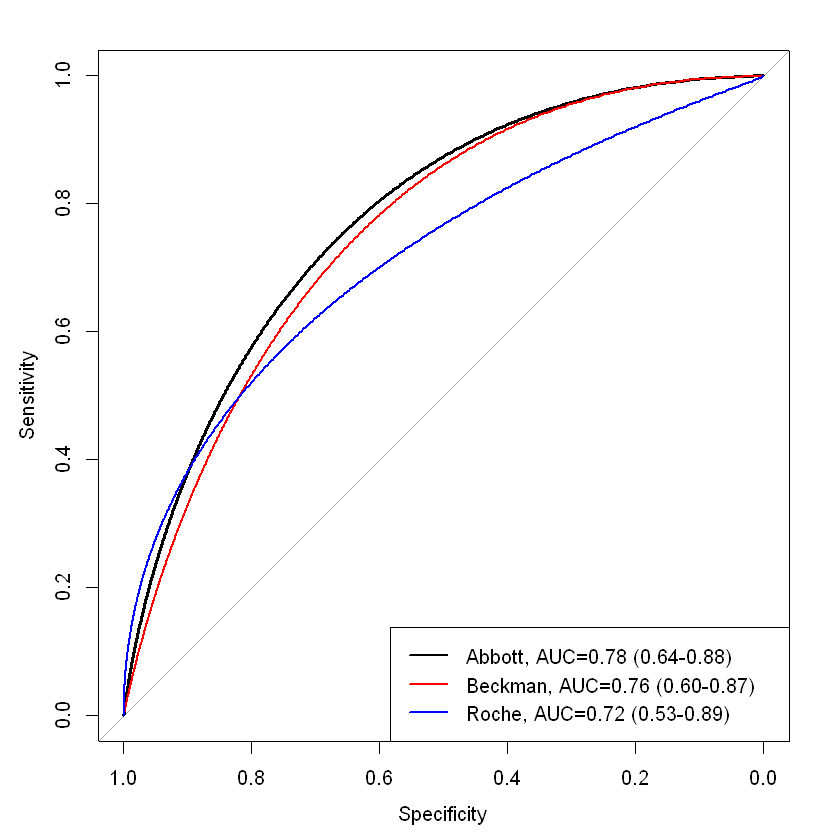

In [48]:
## 0 hour
Roche_T0_ROC=roc(mydata$MI, mydata$Roche_T0,smooth=TRUE)
Beckman_T0_ROC=roc(mydata$MI, mydata$Beckman_T0,smooth=TRUE)
Abbott_T0_ROC=roc(mydata$MI, mydata$Abbott_T0,smooth=TRUE)
Roche_T0_ROC
ci.auc(Roche_T0_ROC)
Beckman_T0_ROC
ci.auc(Beckman_T0_ROC)
Abbott_T0_ROC
ci.auc(Abbott_T0_ROC)
Abbott_T0_ROC
plot(Abbott_T0_ROC,lty=1,lwd=3)
plot(Beckman_T0_ROC,add=TRUE,col="red")
plot(Roche_T0_ROC,add=TRUE,col="blue")
legend("bottomright",legend=c("Abbott, AUC=0.78 (0.64-0.88)",
                              "Beckman, AUC=0.76 (0.60-0.87)",
                              "Roche, AUC=0.72 (0.53-0.89)"),
       col=c("black","red","blue"),lwd=2)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = mydata$MI, predictor = mydata$Roche_T0)

Data: mydata$Roche_T0 in 116 controls (mydata$MI 0) < 11 cases (mydata$MI 1).
Area under the curve: 0.7304

95% CI: 0.5424-0.9184 (DeLong)


Call:
roc.default(response = mydata$MI, predictor = mydata$Beckman_T0)

Data: mydata$Beckman_T0 in 116 controls (mydata$MI 0) < 11 cases (mydata$MI 1).
Area under the curve: 0.7633

95% CI: 0.6224-0.9043 (DeLong)


Call:
roc.default(response = mydata$MI, predictor = mydata$Abbott_T0)

Data: mydata$Abbott_T0 in 116 controls (mydata$MI 0) < 11 cases (mydata$MI 1).
Area under the curve: 0.7853

95% CI: 0.6609-0.9097 (DeLong)


Call:
roc.default(response = mydata$MI, predictor = mydata$Abbott_T0)

Data: mydata$Abbott_T0 in 116 controls (mydata$MI 0) < 11 cases (mydata$MI 1).
Area under the curve: 0.7853

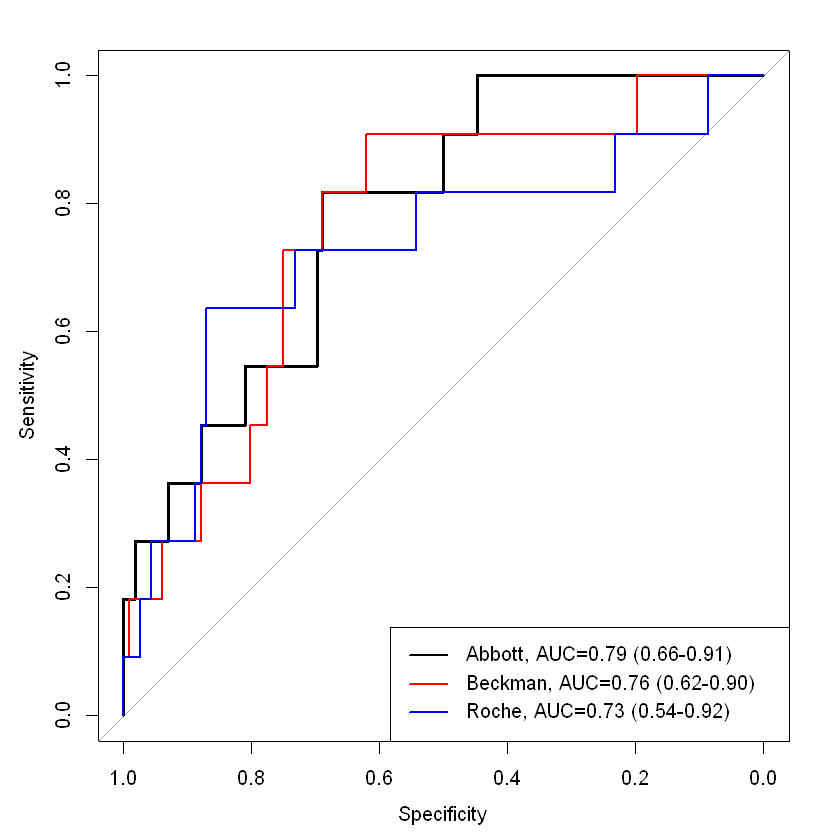

In [49]:
## 0 hour
Roche_T0_ROC=roc(mydata$MI, mydata$Roche_T0)
Beckman_T0_ROC=roc(mydata$MI, mydata$Beckman_T0)
Abbott_T0_ROC=roc(mydata$MI, mydata$Abbott_T0)
Roche_T0_ROC
ci.auc(Roche_T0_ROC)
Beckman_T0_ROC
ci.auc(Beckman_T0_ROC)
Abbott_T0_ROC
ci.auc(Abbott_T0_ROC)
Abbott_T0_ROC
plot(Abbott_T0_ROC,lty=1,lwd=3)
plot(Beckman_T0_ROC,add=TRUE,col="red")
plot(Roche_T0_ROC,add=TRUE,col="blue")
legend("bottomright",legend=c("Abbott, AUC=0.79 (0.66-0.91)",
                              "Beckman, AUC=0.76 (0.62-0.90)",
                              "Roche, AUC=0.73 (0.54-0.92)"),
       col=c("black","red","blue"),lwd=2)